<a href="https://colab.research.google.com/github/svetaafonnikova/fbb_transcriptomics/blob/main/Pr2_EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание: Модифицируйте EM-алгоритм таким образом, чтобы он находил не два, а три кластера на наших данных.

## EM-алгоритм для кластеризации двумерных данных

На этом шаге мы step-by-step разберём, как работает EM-алгоритм для определения максимально правдоподобных кластеров в данных на плоскости.

Для начала загрузим датасет, с которым будем работать:

In [ ]:
!gdown --id 17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=17mf6RUEFOJ19t2zNuFlswSUs7MODwLlk
To: /content/EM_dataset.csv
100% 12.6k/12.6k [00:00<00:00, 12.6MB/s]


Теперь посмотрим, что он из себя представляет, построив диаграмму рассеяния (да, именно так переводится *scatterplot*):

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style("ticks")
df = pd.read_csv("EM_dataset.csv")
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, color="grey", linewidth=0, ax=ax)
ax.grid(alpha=0.3)

Теперь разберёмся с тем, как именно реализуется алгоритм EM.

Допустим, мы ожидаем увидеть тут два кластера. Априортное распределение количества точек в кластерах $\phi$ ($p(y)$) будет распределено биномиально (то есть есть некоторая вероятность, что точки принадлежат к одному или другому кластеру). Иногда эту вероятность имеет смысл задать явно (когда у нас действительно есть представление о том, как точки должны быть распределены между кластерами), однако в любом случае она будет оптимизироваться и далее.

Вероятность того, что точка принадлежит к кластеру ($p(x | y)$) распределена по Гауссиане с параметрами $\mu$ и $\sigma$.

Таким образом, наша система описывается следующими параметрами
$\theta := \phi, \mu_1, \sigma_1, \mu_2, \sigma_2$. Зададим их изначально случайно.

In [ ]:
import numpy as np

def get_random_psd(n=2):
    x = np.random.normal(0, 1, size=(n, n))
    return np.dot(x, x.transpose())

params = {    
    "phi1" : np.random.uniform(0, 1), # Доля точек, принадлежащих к кластеру 1
    "phi2" : np.random.uniform(0, 1), # Доля точек, принадлежащих к кластеру 2

    "mu1" : np.random.normal(0, 1, size=2), # Центр распределения 1
    "mu2" : np.random.normal(0, 1, size=2), # Центр распределения 2
    "mu3" : np.random.normal(0, 1, size=2), # Центр распределения 3
    
    "sigma1" : get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma2" : get_random_psd(), # У 2d Гауссианы таким образом задаётся дисперсия
    "sigma3" : get_random_psd() # У 2d Гауссианы таким образом задаётся дисперсия

}

for param in params:
  print(f"{param}:")
  print(params[param], "\n")

phi1:
0.3557558189047747 

phi2:
0.6252168652517022 

mu1:
[ 0.07499765 -1.25331591] 

mu2:
[-1.22093102  1.32693936] 

mu3:
[-0.83860717 -0.02528712] 

sigma1:
[[12.47311927  2.32536528]
 [ 2.32536528  0.51088291]] 

sigma2:
[[ 1.37793537 -1.95205514]
 [-1.95205514  3.00074119]] 

sigma3:
[[ 3.6890215  -0.03879402]
 [-0.03879402  2.5405027 ]] 



Теперь отрисуем эти распределения (пока без точек):

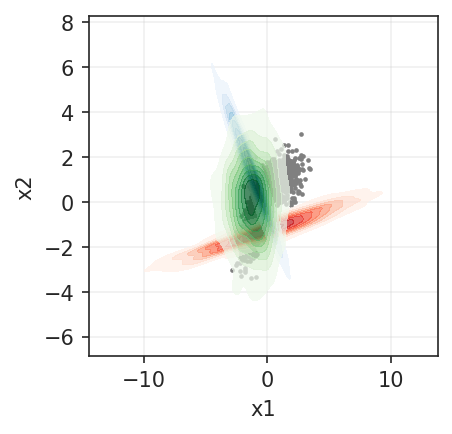

In [ ]:
import scipy.stats as stats

hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)
hist3 = stats.multivariate_normal(params["mu3"], params["sigma3"]).rvs(size=1000)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, color="grey")
sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=ax, cmap="Reds", fill=True, alpha=0.7)
sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=ax, cmap="Blues", fill=True, alpha=0.7)
sns.kdeplot(x=hist2[:, 0], y=hist3[:, 1], ax=ax, cmap="Greens", fill=True, alpha=0.7)
ax.grid(alpha=0.3)

Итак, мы получили изначальные параметры, которые мы будем оптимизировать. Как происходит оптимизация этих параметров в EM-алгоритме? В целом логика примерно та же, что и в K-Means (для тех, кто знаком, если не знакомы &mdash; мы будем разбирать этот алгоритм в ходе курса позднее).

На E-шаге мы будем для каждой точки считать вероятности принадлежности каждой из точек к тому или иному кластеру.

$$b_i = P(b | x_i) = \frac{P(x_i|b)P(b)}{P(x_i|a)P(a) + P(x_i|b)P(b)} = \frac{(\mathrm{Likelihood\;of\;x_i\;from\;b} )*(\mathrm{Prior\;probability\;of\;b})}{\mathrm{Total\;probability\;of\;x_i}} = \frac{A * B}{C} = \frac{D}{C}$$

В логарифмической форме это будет выглядеть как $$\log{b_i} = \log{P(b_i|x)} = \log{P(x_i|b)} + \log{P(b)} - \log{(P(x_i|a)P(a) + P(x_i|b)P(b))} = \mathrm{LogLikelihood} + \mathrm{Prior} - \mathrm{Total\;probability} = \log{A} + \log{B} - \log{C}$$

<b>Подсказка для понимания</b>: представьте, что $P(a) = P(b) = 0.5$. Выражение упростится до $$b_i = P(b|x_i) = \frac{P(x_i|b)}{P(x_i|b) + P(x_i|a)},$$ то есть до отношения правдоподобия того, что точка порождена распределением $b$, к сумме правдоподобий того, что точка порождена распределением $b$ и распределением $a$.

In [ ]:
from scipy.special import logsumexp

X = df.values

def E_step(X, params, draw=False):
  LogLikelihood = A = np.log([
      stats.multivariate_normal(params["mu1"], params["sigma1"]).pdf(X), 
      stats.multivariate_normal(params["mu2"], params["sigma2"]).pdf(X),
      stats.multivariate_normal(params["mu3"], params["sigma3"]).pdf(X)
  ])
  logPrior = B = np.log([1 - params["phi1"] - params["phi2"], params["phi2"], params["phi1"]])
  logPosterior = D = logPrior + LogLikelihood.T
  RealSoftMax = C = logsumexp(logPosterior, axis=1)
  probabilities = np.exp(logPosterior - np.array([RealSoftMax]).T)

  if draw:
    hist1 = stats.multivariate_normal(params["mu1"], params["sigma1"]).rvs(size=1000)
    hist2 = stats.multivariate_normal(params["mu2"], params["sigma2"]).rvs(size=1000)
    hist3 = stats.multivariate_normal(params["mu3"], params["sigma3"]).rvs(size=1000)

    fig, axes = plt.subplots(figsize=(6, 3), dpi=150, ncols=2)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=probabilities[:, 0], linewidth=0,
                    palette="coolwarm", ax=axes[1], s=3, alpha=1)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], linewidth=0, ax=axes[0], s=3, alpha=1, color="grey")
    sns.kdeplot(x=hist1[:, 0], y=hist1[:, 1], ax=axes[0], cmap="Reds", fill=True, alpha=0.5)
    sns.kdeplot(x=hist2[:, 0], y=hist2[:, 1], ax=axes[0], cmap="Blues", fill=True, alpha=0.5)
    sns.kdeplot(x=hist3[:, 0], y=hist3[:, 1], ax=axes[0], cmap="Greens", fill=True, alpha=0.5)
    axes[0].grid(alpha=0.3)
    axes[1].grid(alpha=0.3)
    #axes[2].grid(alpha=0.3)
    axes[1].legend().remove()
    axes[0].set_xlim(-4, 4)
    axes[1].set_xlim(-4, 4)
    #axes[2].set_xlim(-4, 4)
    axes[0].set_ylim(-4, 4)
    axes[1].set_ylim(-4, 4)
    #axes[2].set_ylim(-4, 4)
    plt.show()

  return RealSoftMax, probabilities

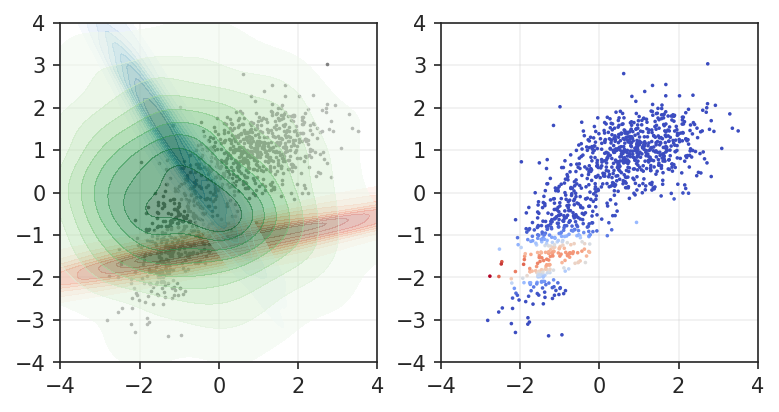

In [ ]:
total_prob, probabilities = E_step(X, params, draw=True)

На следующеи шаге мы будем оптимизировать параметр $\theta$ по тому, как мы определили принадлежность точек к кластерам на E-шаге.

In [ ]:
def M_step(X, params, probabilities):
  prob_1 = probabilities[:, 0]
  prob_2 = probabilities[:, 1]
  prob_3 = probabilities[:, 2]

  # Вычисление новых значений
  # Пропорция = prior
  phi1 = prob_1.sum() / len(X)
  phi2 = prob_2.sum() / len(X)

  # Среднее
  mu1 = prob_1.dot(X) / np.sum(prob_1)
  mu2 = prob_2.dot(X) / np.sum(prob_2)
  mu3 = prob_3.dot(X) / np.sum(prob_3)

  # Дисперсия
  sigma1 = (X - mu1).T.dot((X - mu1) * np.array([prob_1]).T) / np.sum(prob_1)
  sigma2 = (X - mu2).T.dot((X - mu2) * np.array([prob_2]).T) / np.sum(prob_2)
  sigma3 = (X - mu3).T.dot((X - mu3) * np.array([prob_3]).T) / np.sum(prob_3)
  
  return {
      "phi1" : phi1,
      "phi2" : phi2,
      "mu1" : mu1, "mu2" : mu2, "mu3" : mu3,
      "sigma1": sigma1, "sigma2": sigma2, "sigma3" : sigma3
  }

Сделаем так, чтобы это выполнялось до тех пор, пока LogLikelihood не перестанет уменьшаться меньше, чем на 0.0001.

In [ ]:
def run_EM(X, params, draw=False):
    import imageio
    avg_allprob = []

    while True:
        allprob, probabilities = E_step(X, params, draw=draw)
        avg_allprob.append(np.mean(allprob))
        if len(avg_allprob) > 2 and abs(avg_allprob[-1] - avg_allprob[-2]) < 0.00001:
            break
        params = M_step(X, params, probabilities)
        
    loglikelihood, probabilities = E_step(X, params)
    forecasts = np.argmax(probabilities, axis=1)
    return forecasts, probabilities, avg_allprob

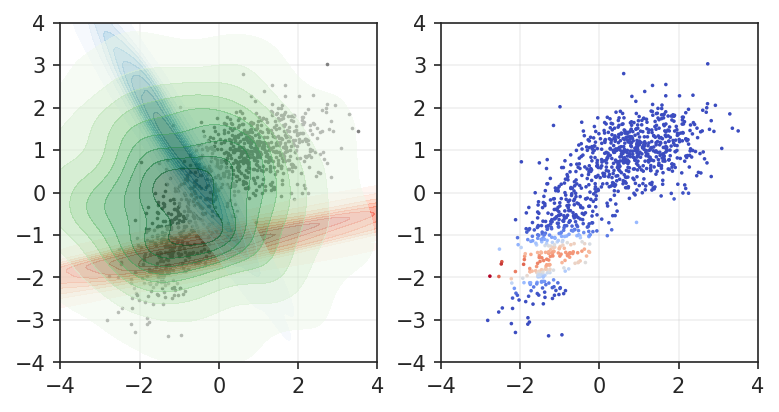

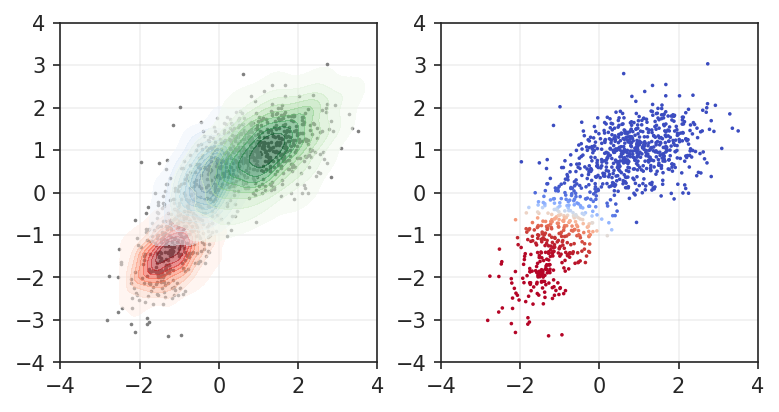

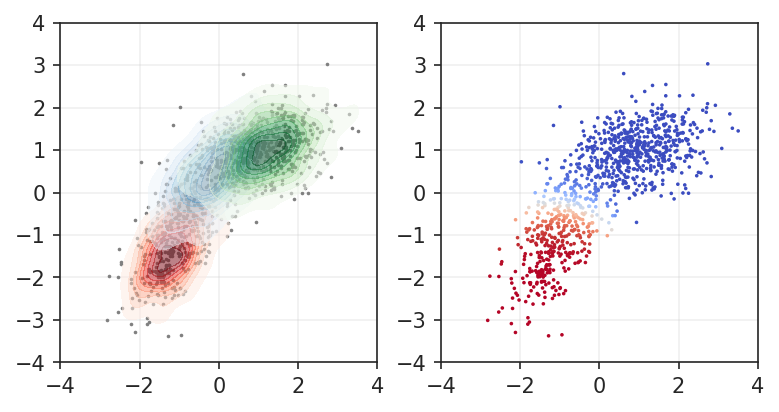

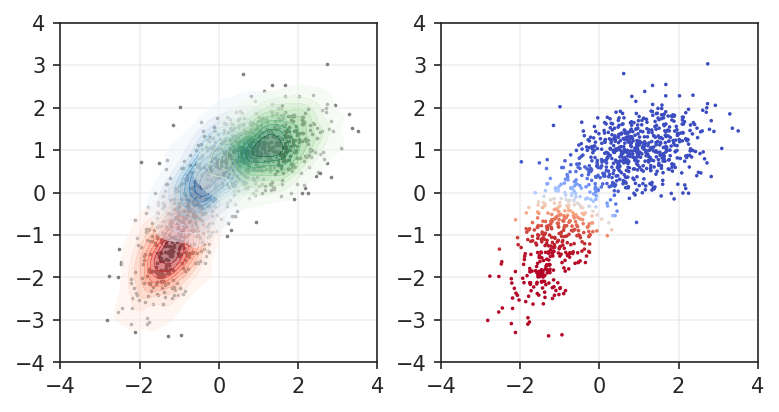

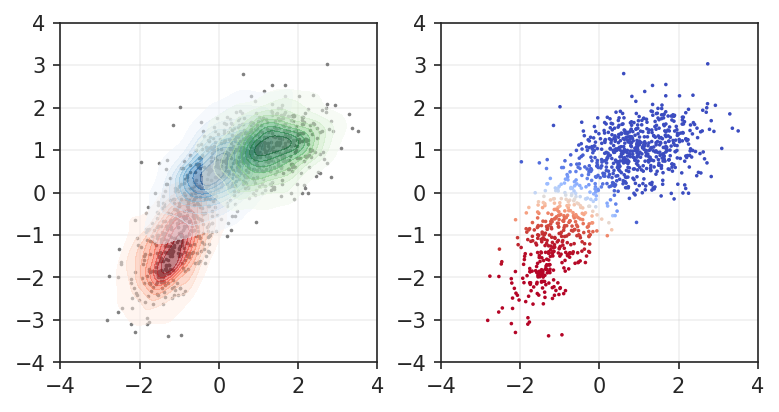

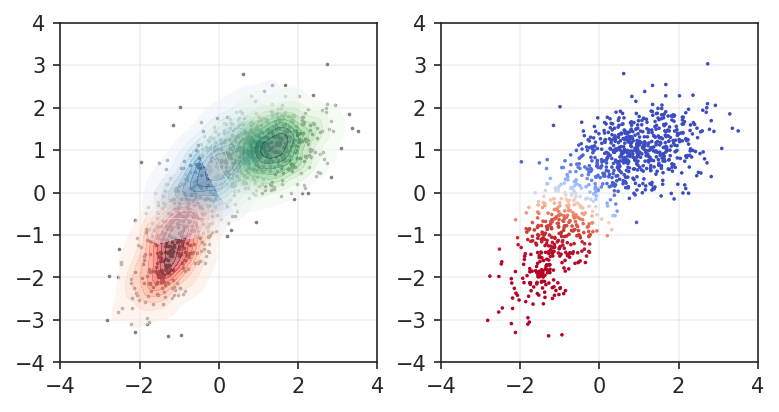

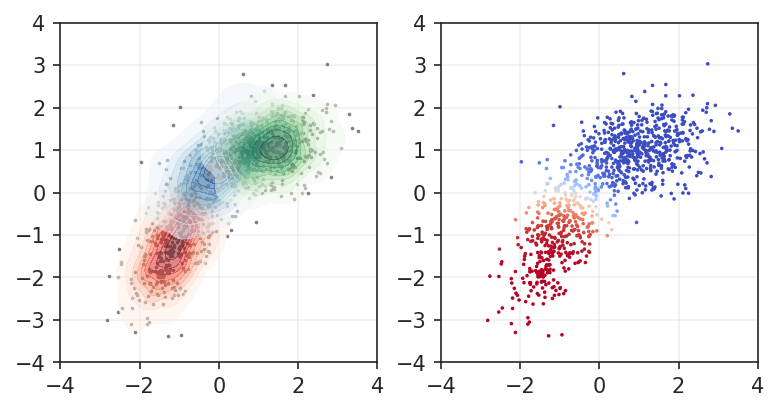

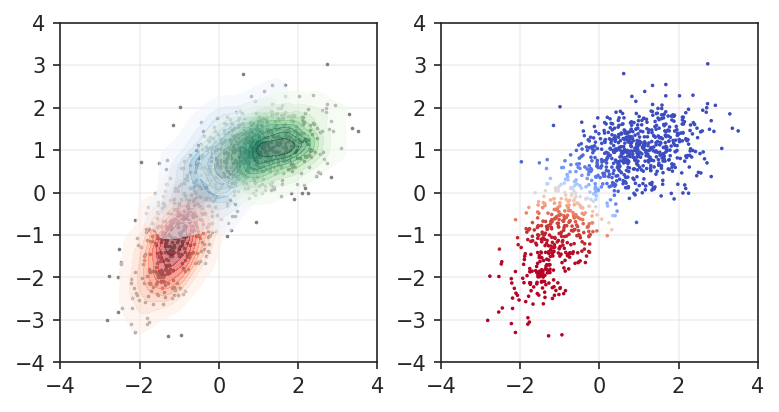

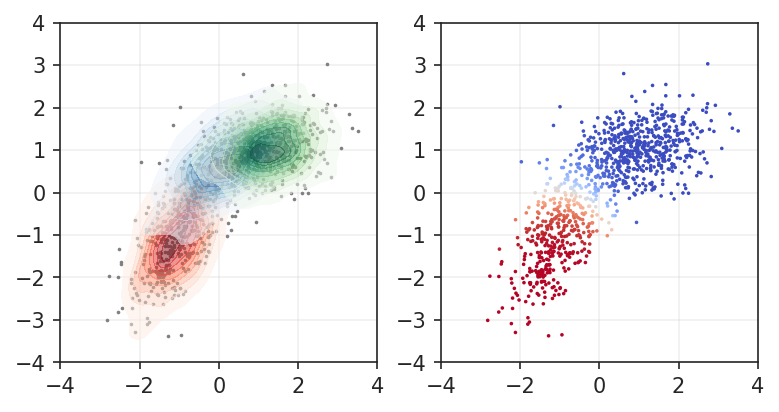

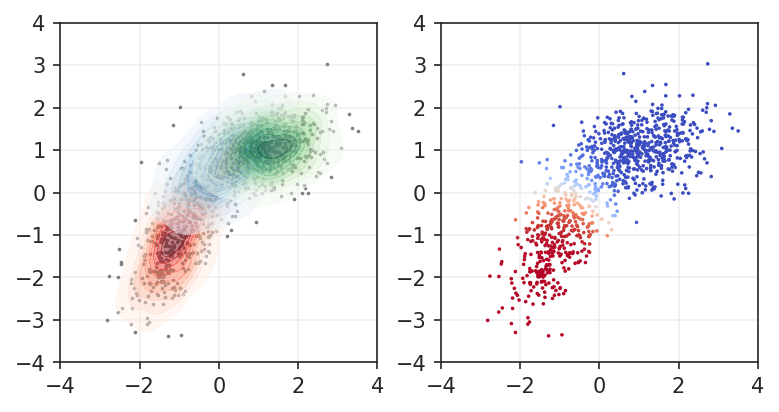

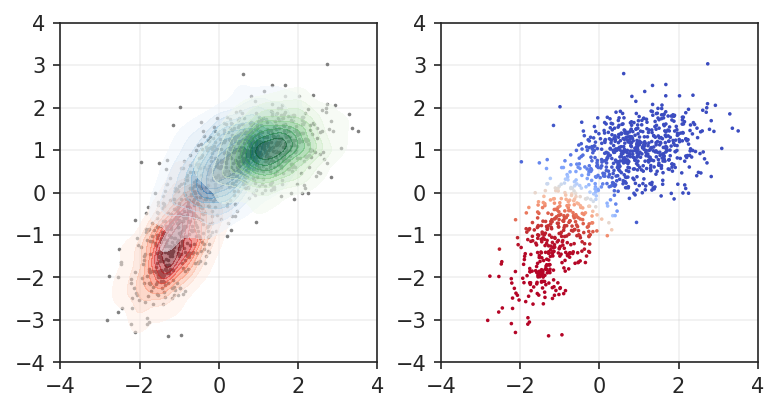

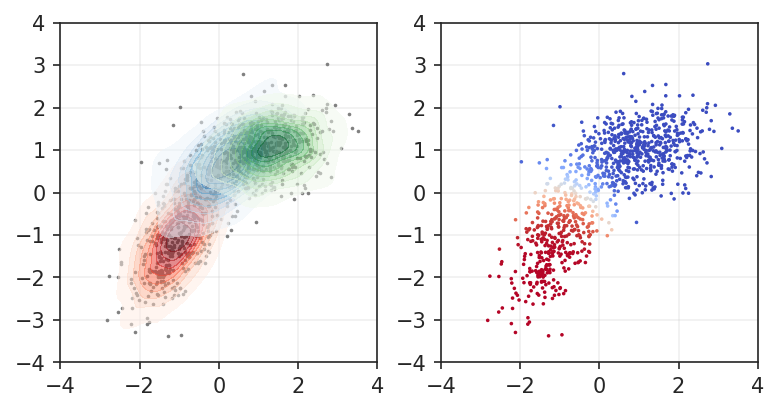

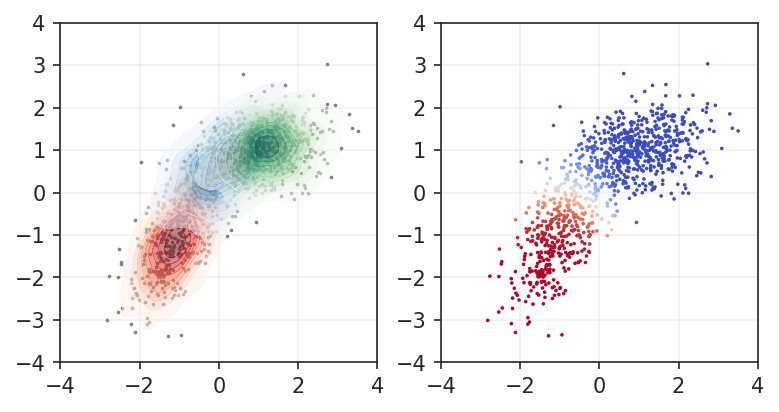

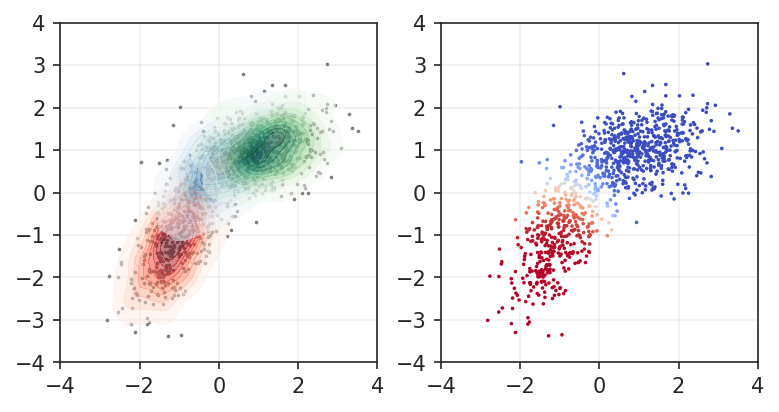

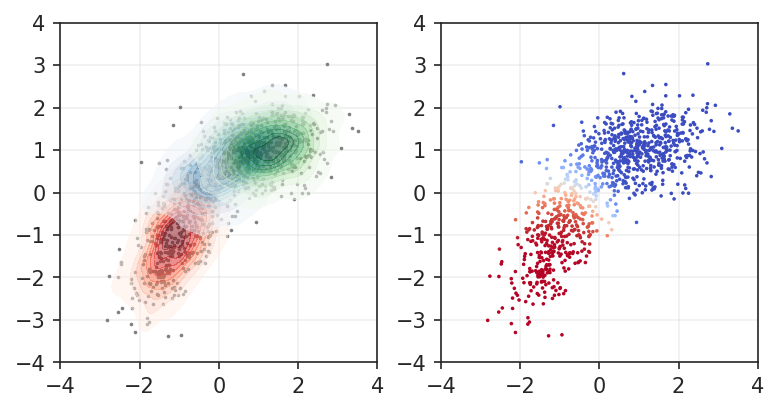

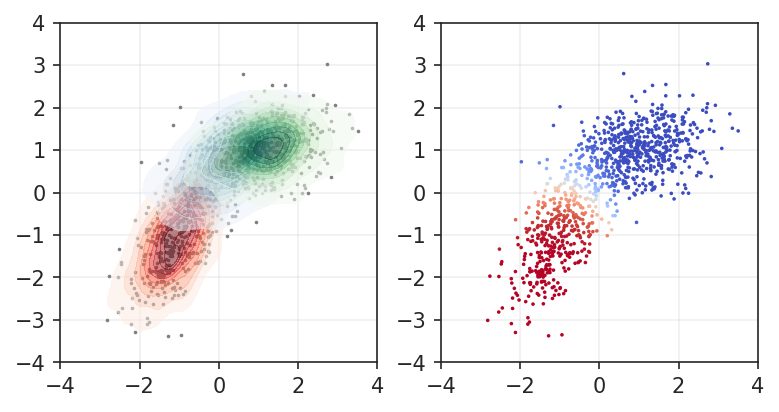

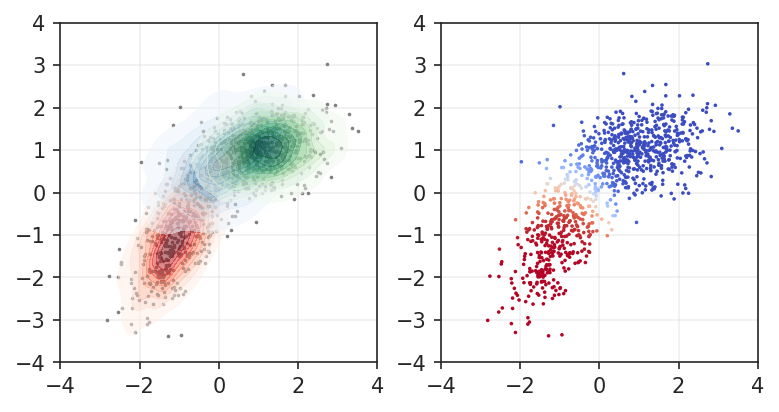

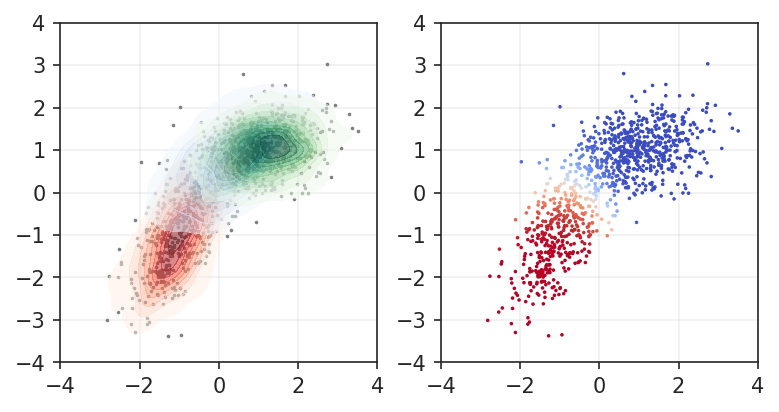

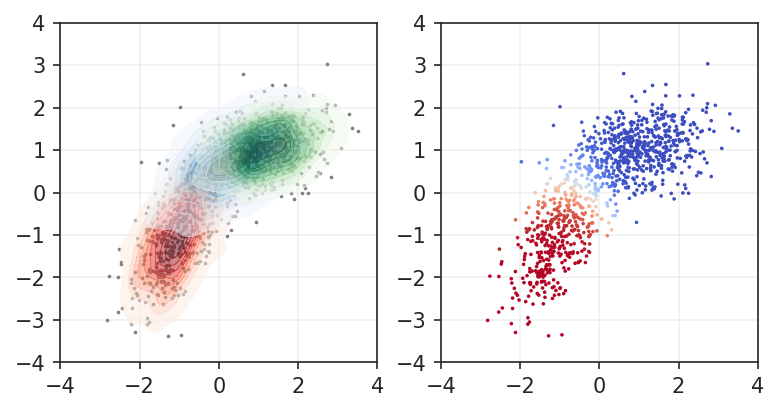

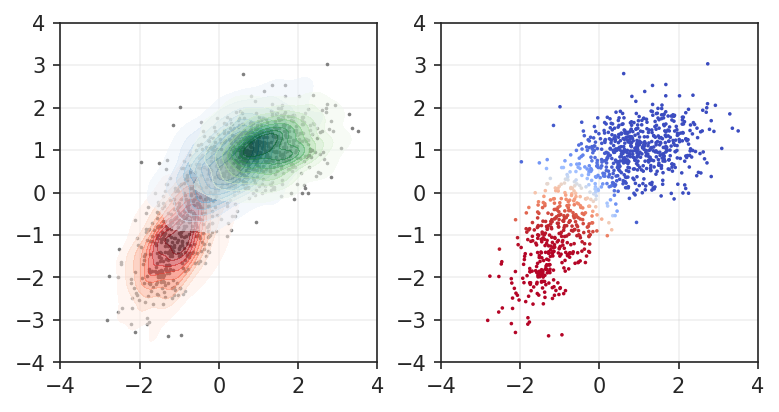

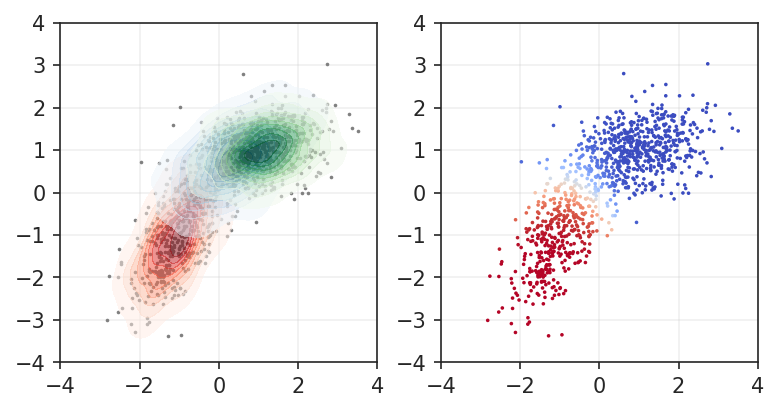

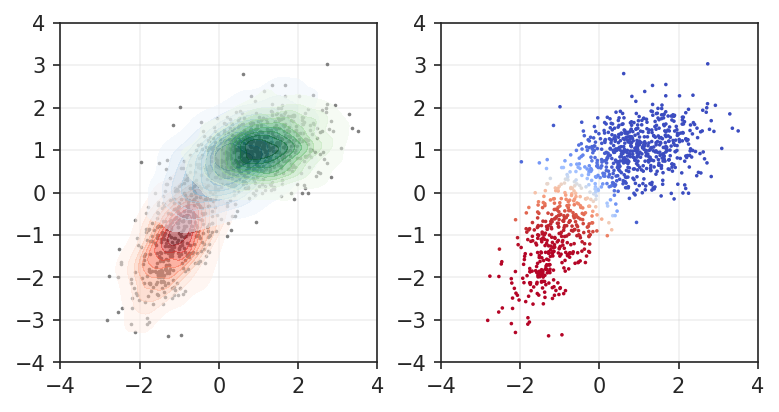

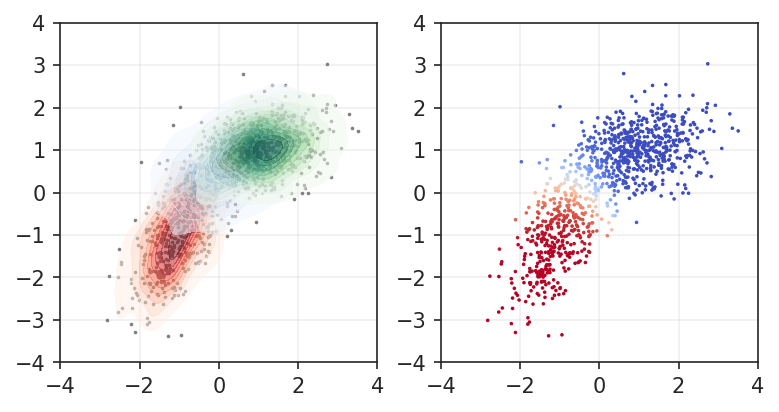

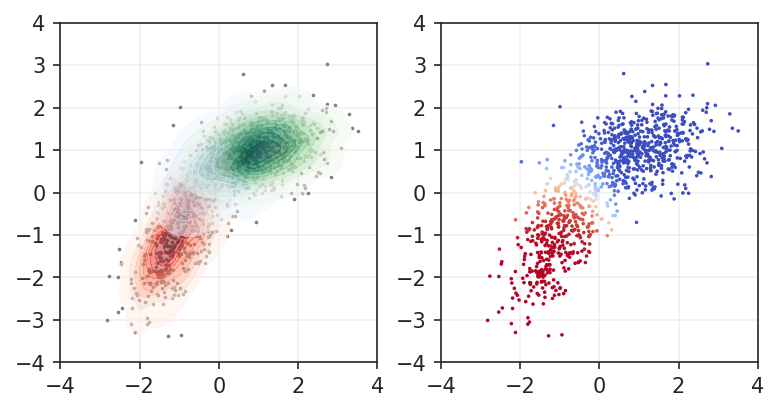

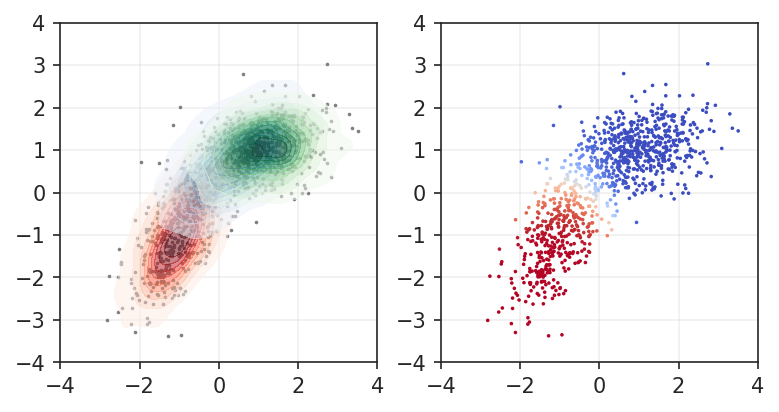

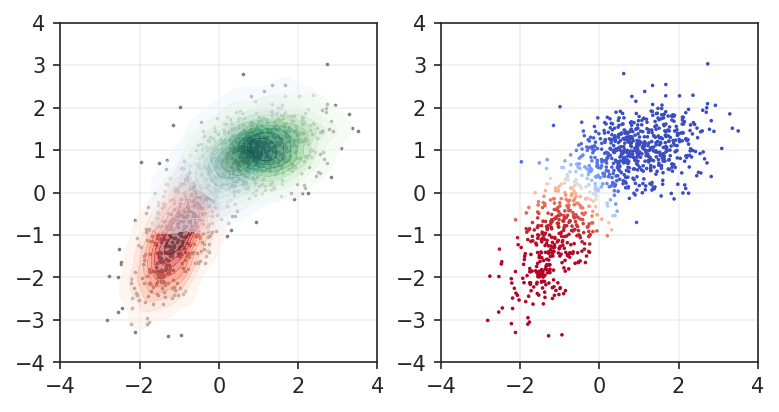

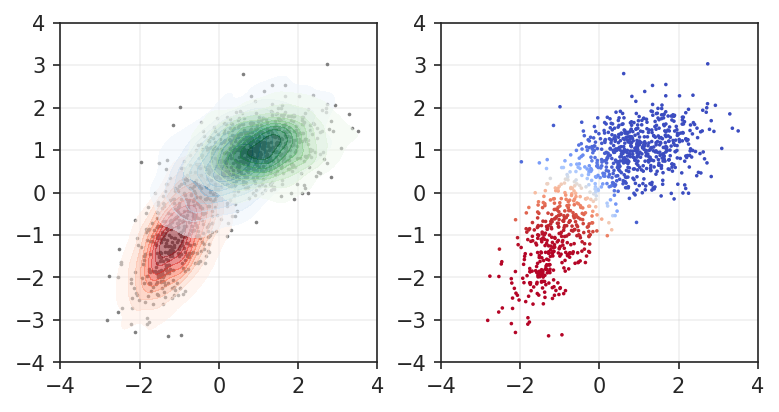

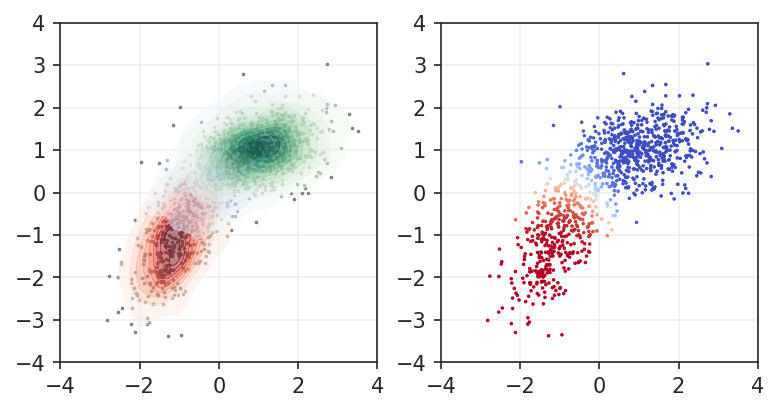

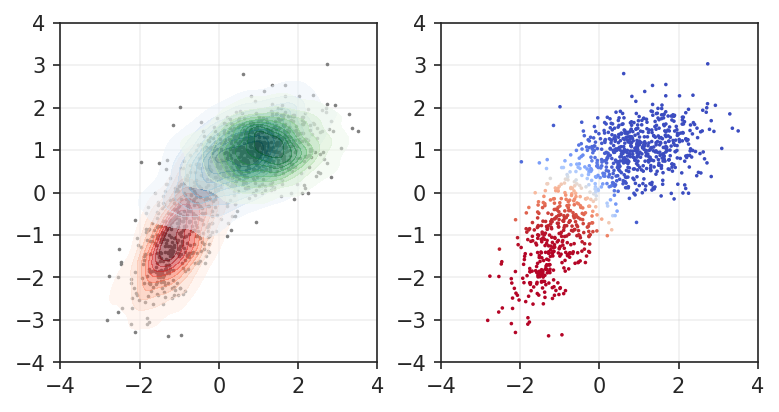

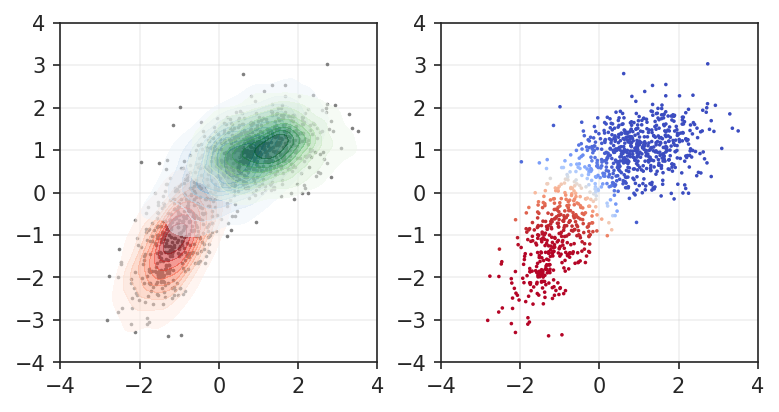

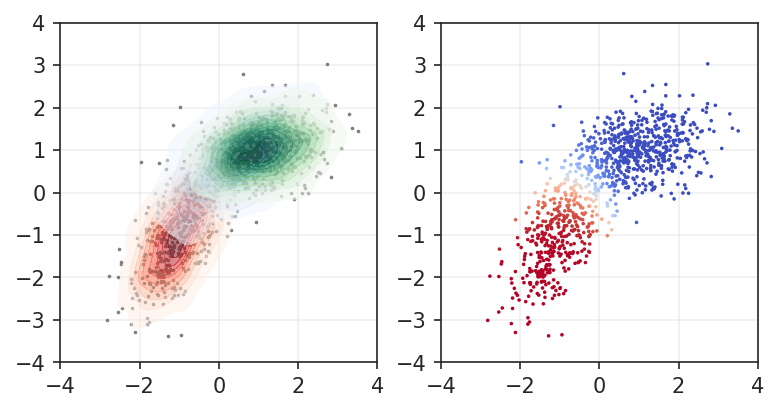

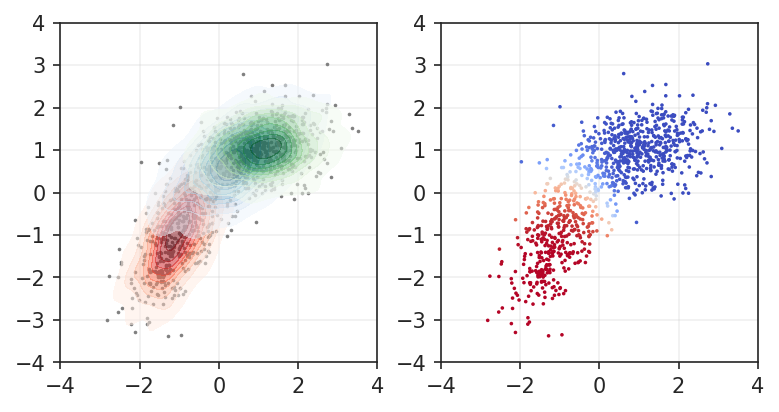

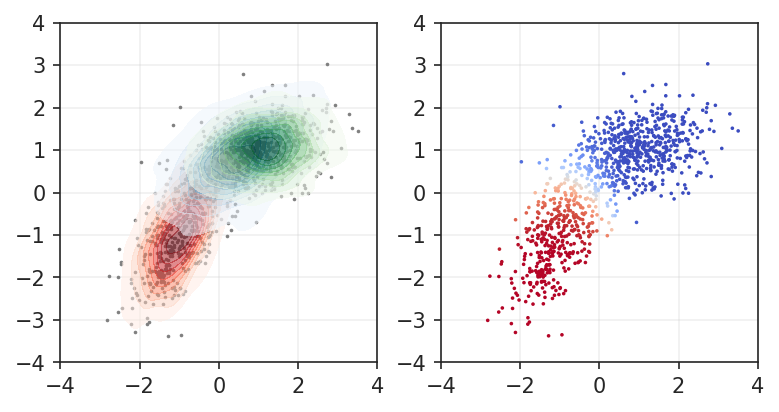

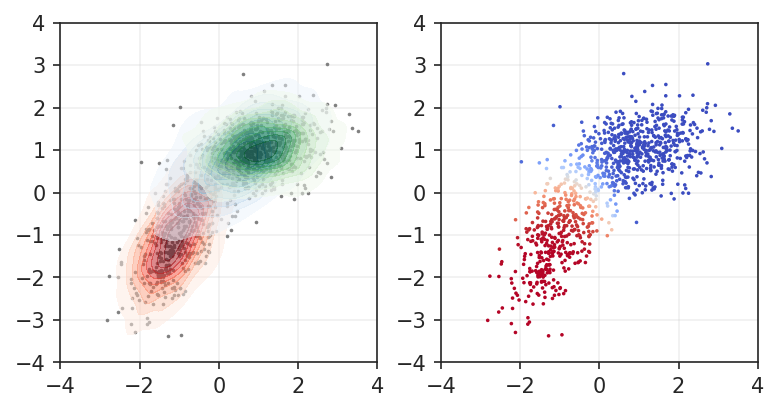

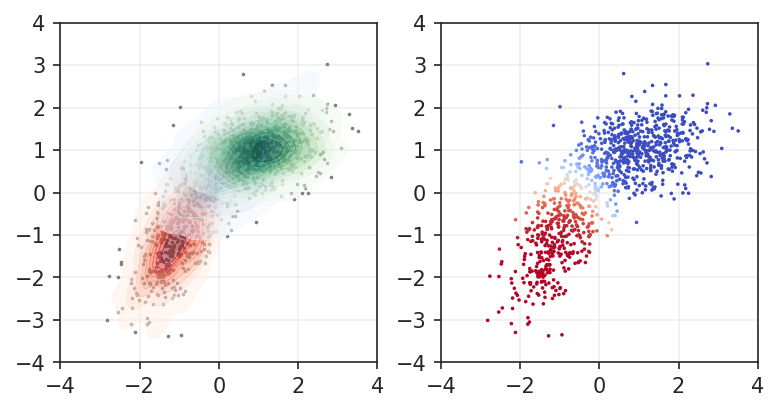

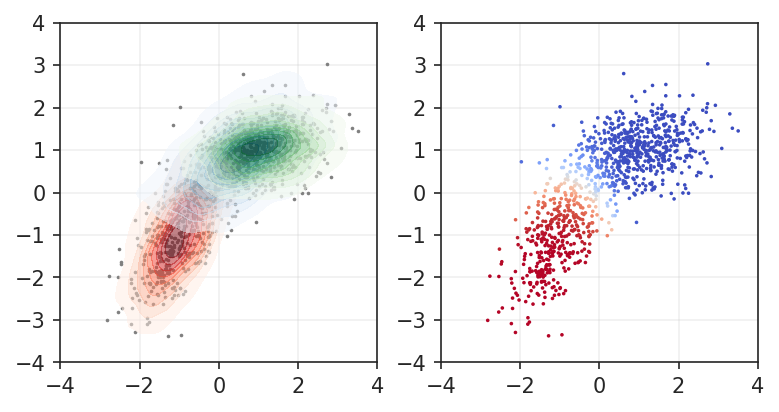

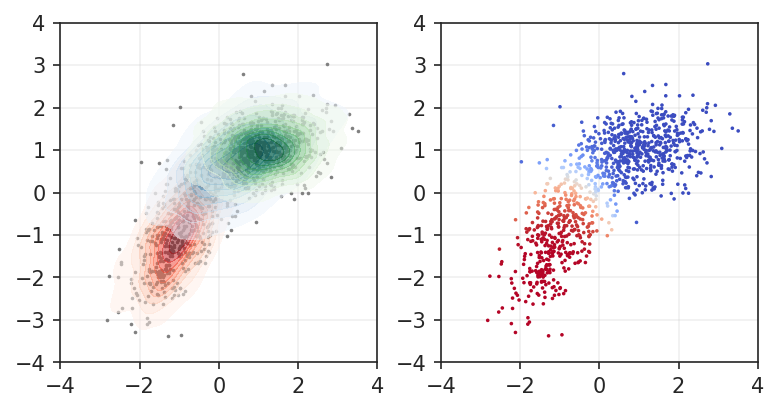

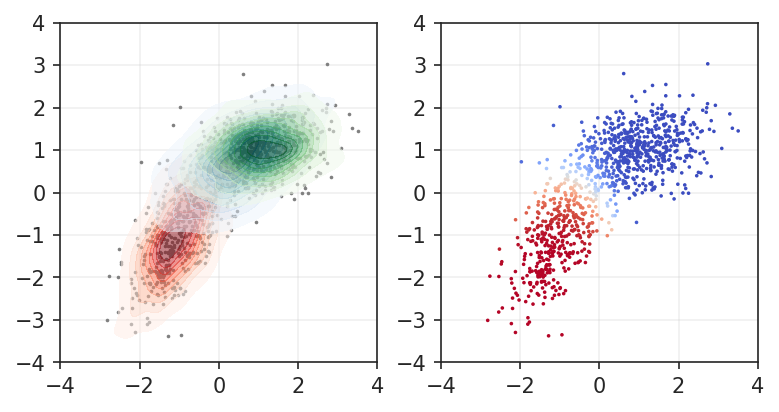

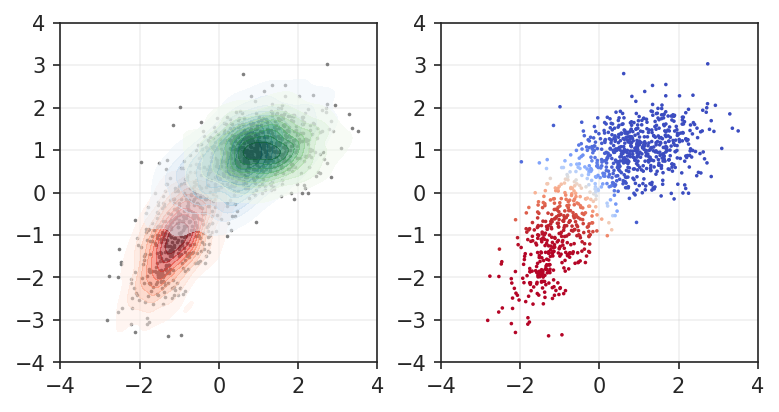

In [ ]:
pred, prob, allprob = run_EM(X, params, draw=True)

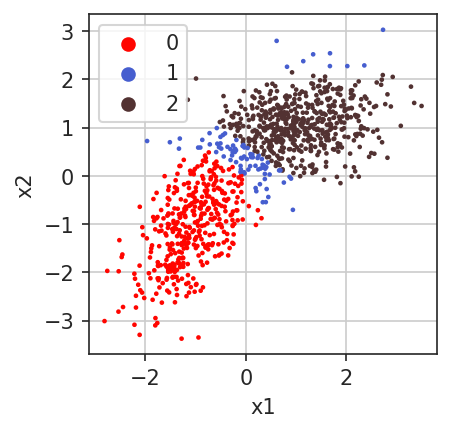

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(x="x1", y="x2", data=df, s=5, linewidth=0, ax=ax, hue=pred,
                palette={0: sns.color_palette("autumn", n_colors=50)[0],
                         1: sns.color_palette("coolwarm", n_colors=50)[1],
                         2: sns.color_palette("pink", n_colors=50)[2]})
ax.grid(alpha=1)